In [1]:
from main import main, training_loop


In [ ]:
for model in ["basic", "in_series", "cnn_lstm"]:
    training_loop(model)

('lemmas',)


In [22]:
from pathlib import Path
import joblib
import pandas as pd
res = []
res_path = Path("./results/")
for arch_type in res_path.iterdir():
    for _dir in arch_type.iterdir():
        for file in _dir.iterdir():
            one_res = joblib.load(file)
            res.append(
                {
                    "arch_type": arch_type.name,
                    "vec_model": _dir.name,
                    "preprocessing": file.name,
                    "best_trail": max(one_res.best_trial.intermediate_values.values()),
                }
            )

In [66]:
df = pd.DataFrame.from_records(res)



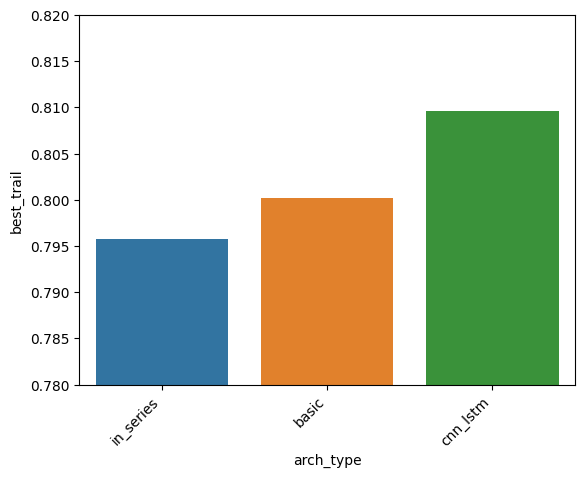

In [59]:
 make_barplot(df, "arch_type")

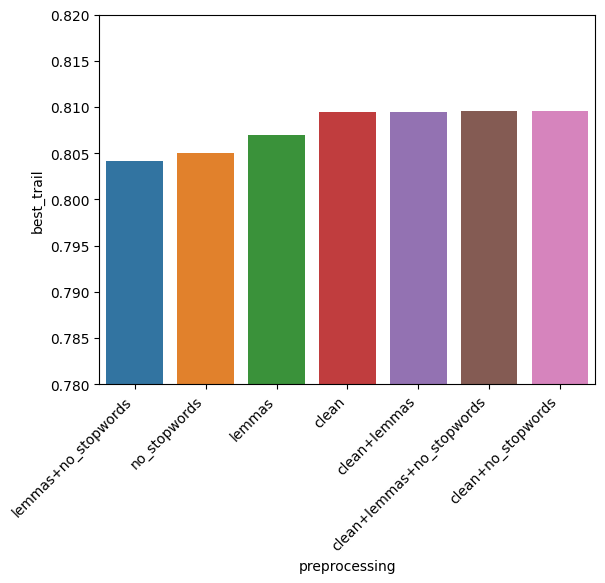

In [60]:
make_barplot(df, "preprocessing")

In [79]:
df

,arch_type,vec_model,preprocessing,best_trail
0,basic,nkjp+wiki-forms-all-100-cbow-ns,lemmas+no_stopwords,0.787865
1,basic,nkjp+wiki-forms-all-100-cbow-ns,clean+lemmas+no_stopwords,0.787865
2,basic,nkjp+wiki-forms-all-100-cbow-ns,clean+no_stopwords,0.766728
3,basic,nkjp+wiki-forms-all-100-cbow-ns,no_stopwords,0.767488
4,basic,nkjp+wiki-forms-all-100-cbow-ns,clean,0.787865
...,...,...,...,...
307,cnn_lstm,nkjp+wiki-forms-all-300-cbow-hs,clean+lemmas+no_stopwords,0.802616
308,cnn_lstm,nkjp+wiki-forms-all-300-cbow-hs,clean+no_stopwords,0.802616
309,cnn_lstm,nkjp+wiki-forms-all-300-cbow-hs,no_stopwords,0.805049
310,cnn_lstm,nkjp+wiki-forms-all-300-cbow-hs,clean,0.801095


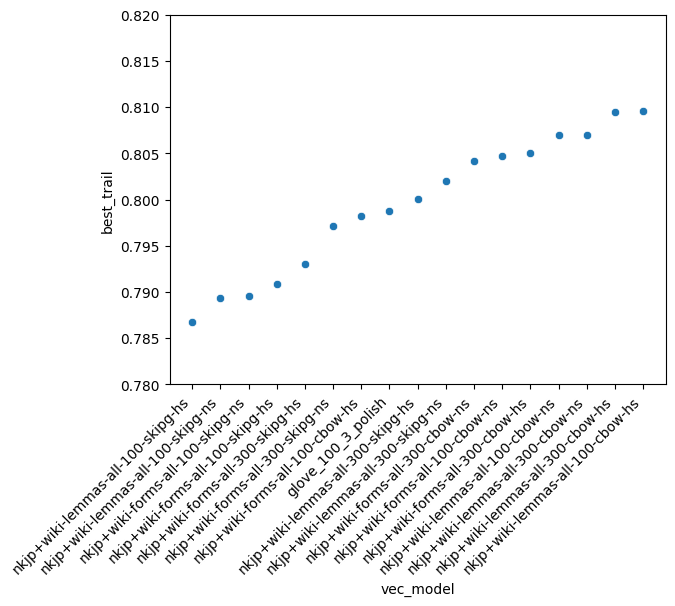

In [61]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt






In [171]:
class PlotMaker:

    def __init__(self, res_df):
        plt.figure(figsize=(10, 6))
        self.df = self.clean_df(res_df)
        self.values = list(res_df.drop("best_trail", axis=1).columns)

    @staticmethod
    def clean_df(res_df):
        res_df["vec_model"] = res_df["vec_model"].str.removesuffix(".txt")
        res_df["preprocessing"] = res_df["preprocessing"].str.removesuffix(".pkl")
        res_df = res_df.sort_values(by="best_trail")
        return res_df

    def make_barplot(self, group_by, ylim_low=0.78, ylim_high=0.82):
        data = self.get_data(group_by)
        barplot = sns.barplot(data, x=data.index, y="best_trail")
        self.format_plot(ylim_low, ylim_high)
        barplot.figure.savefig(f"{group_by}_barplot.png", bbox_inches="tight")

    def make_scatterplot(self, x, hue, ylim_low=0.78, ylim_high=0.82):
        scatterplot = sns.scatterplot(self.df, x=x, y="best_trail",  hue=hue)
        self.format_plot(ylim_low, ylim_high)
        scatterplot.figure.savefig(f"{x}_by_{hue}_scatterplot.png", bbox_inches="tight")

    def make_heatmap(self):
        data = self.df.drop("vec_model", axis=1)
        data.pivot(columns=["arch_type", "preprocessing"])
        sns.heatmap(data, cmap="magma", annot=True)


    def get_data(self, group_by):
        return self.df.groupby(group_by).max().sort_values(by="best_trail")

    @staticmethod
    def format_plot(ylim_low=0.78, ylim_high=0.82):
        plt.xticks(rotation=45, ha="right")
        plt.ylim(ylim_low, ylim_high)



plot = PlotMaker(df)
val = plot.values[0]
print(val)

arch_type


<Figure size 1000x600 with 0 Axes>

In [153]:
data = plot.df.drop("vec_model", axis=1)
data.pivot(columns=["arch_type", "preprocessing"]).dropna(axis=1, how="all")

best_trail                                             
arch_type        in_series        basic                    in_series   
preprocessing no_stopwords no_stopwords clean+no_stopwords    lemmas   
0                      NaN          NaN                NaN       NaN  \
1                      NaN          NaN                NaN       NaN   
2                      NaN          NaN           0.766728       NaN   
3                      NaN     0.767488                NaN       NaN   
4                      NaN          NaN                NaN       NaN   
..                     ...          ...                ...       ...   
307                    NaN          NaN                NaN       NaN   
308                    NaN          NaN                NaN       NaN   
309                    NaN          NaN                NaN       NaN   
310                    NaN          NaN                NaN       NaN   
311                    NaN          NaN                NaN       NaN   

                                                                    
arch_type                   basic                       in_series   
preprocessing clean+lemmas lemmas clean+lemmas clean+no_stopwords   
0                      NaN    NaN          NaN                NaN  \
1                      NaN    NaN          NaN                NaN   
2                      NaN    NaN          NaN                NaN   
3                      NaN    NaN          NaN                NaN   
4                      NaN    NaN          NaN                NaN   
..                     ...    ...          ...                ...   
307                    NaN    NaN          NaN                NaN   
308                    NaN    NaN          NaN                NaN   
309                    NaN    NaN          NaN                NaN   
310                    NaN    NaN          NaN                NaN   
311                    NaN    NaN          NaN                NaN   

                                                             ...   
arch_type                   basic                 in_series  ...   
preprocessing lemmas+no_stopwords clean+lemmas+no_stopwords  ...   
0                        0.787865                       NaN  ...  \
1                             NaN                       NaN  ...   
2                             NaN                       NaN  ...   
3                             NaN                       NaN  ...   
4                             NaN                       NaN  ...   
..                            ...                       ...  ...   
307                           NaN                       NaN  ...   
308                           NaN                       NaN  ...   
309                           NaN                       NaN  ...   
310                           NaN                       NaN  ...   
311                           NaN                       NaN  ...   

                                                              
arch_type                                             basic   
preprocessing lemmas+no_stopwords clean+lemmas+no_stopwords   
0                             NaN                       NaN  \
1                             NaN                  0.787865   
2                             NaN                       NaN   
3                             NaN                       NaN   
4                             NaN                       NaN   
..                            ...                       ...   
307                           NaN                       NaN   
308                           NaN                       NaN   
309                           NaN                       NaN   
310                           NaN                       NaN   
311                           NaN                       NaN   

                                                                       
arch_type               cnn_lstm                               basic   
preprocessing clean+no_stopwords clean+lemmas+no_stopwords  

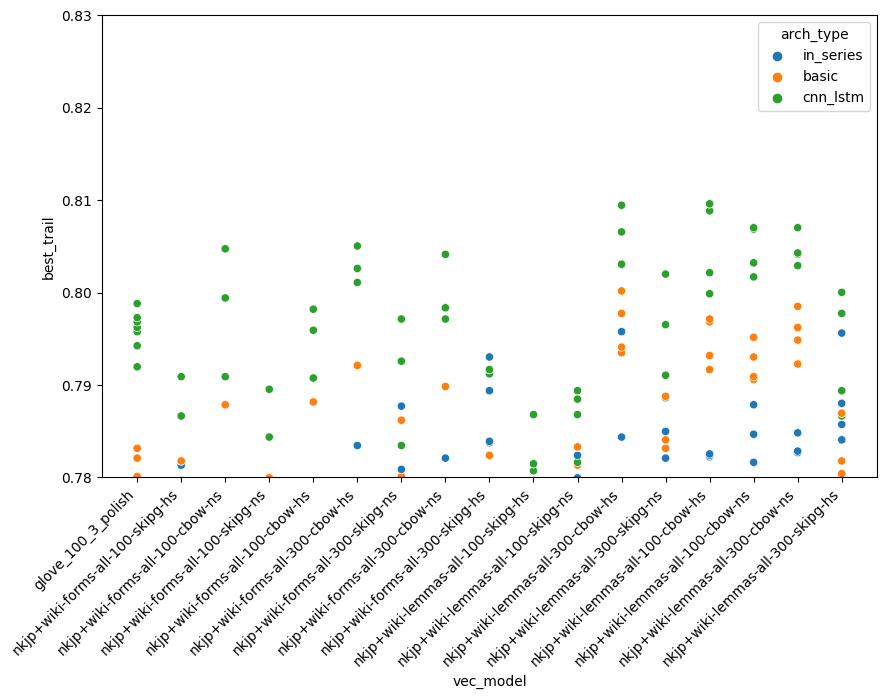

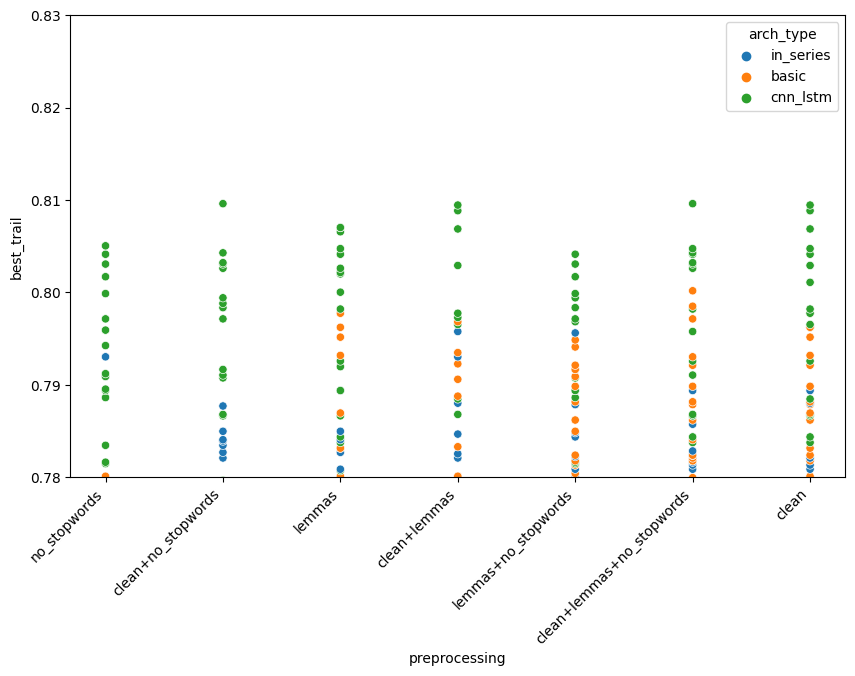

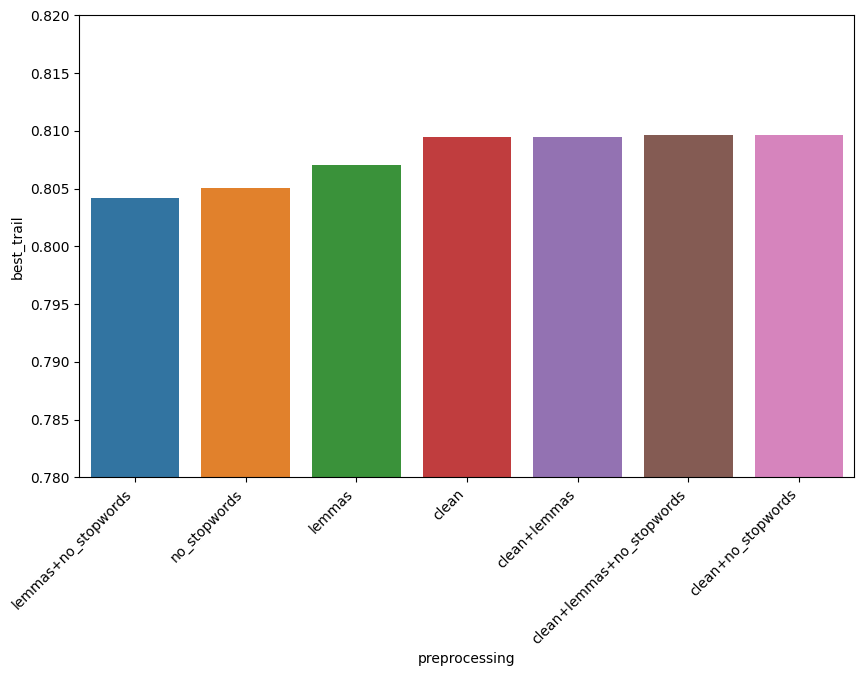

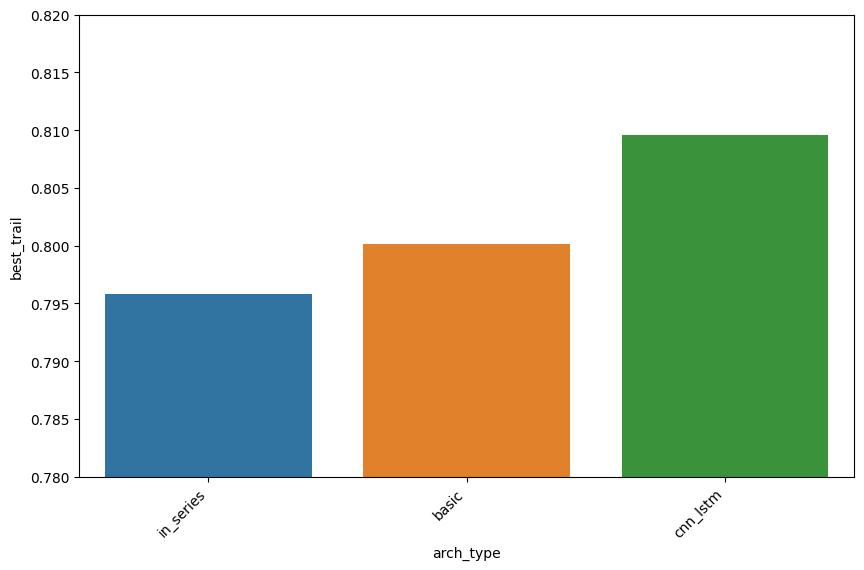

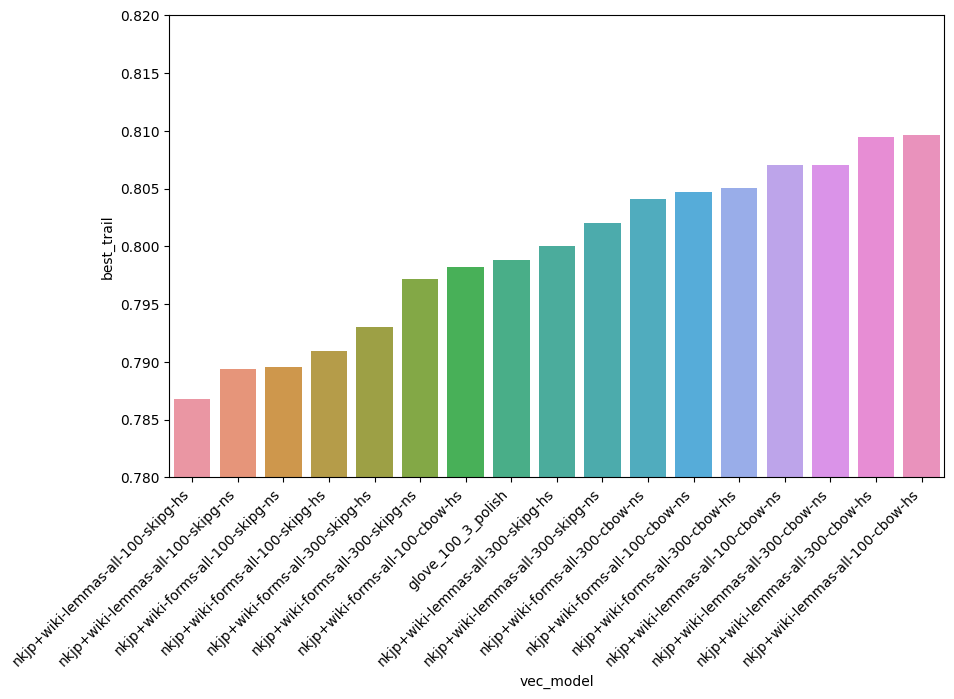

In [172]:
plot = PlotMaker(df)
plot.make_scatterplot("vec_model", val, ylim_high=0.83)
plot = PlotMaker(df)
plot.make_scatterplot("preprocessing", val, ylim_high=0.83)
plot = PlotMaker(df)
plot.make_barplot("preprocessing")
plot = PlotMaker(df)
plot.make_barplot("arch_type")
plot = PlotMaker(df)
plot.make_barplot("vec_model")